In [1]:
import os
from lsst.daf.butler import Butler
from lsst.afw import image as afwImage

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.Utility import runProgram, writePipetaskCmd, getConfigDir, CamType
from lsst.ts.wep.task.EstimateZernikesCwfsTask import EstimateZernikesCwfsTask, EstimateZernikesCwfsTaskConfig

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import rotate
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
butler_repo_orig = 'testData/single_blended_original/phosimData/'
# butler_repo_baseline = 'testData/single_blended_baseline/phosimData/'
butler_repo_baseline = 'testData/single_blended_variable_distance/phosimData/'

In [3]:
butler_orig = Butler(butler_repo_orig)
butler_baseline = Butler(butler_repo_baseline)

In [4]:
dataIdExtra = {
    'instrument': 'LSSTComCam', 
    'detector': 0, 
    'exposure': 4021123106001,
    'visit': 4021123106001
}
dataIdIntra = {
    'instrument': 'LSSTComCam', 
    'detector': 0, 
    'exposure': 4021123106002,
    'visit': 4021123106002
}
donutStampsExtra = butler_baseline.get('donutStampsExtra', dataId=dataIdExtra, collections='ts_phosim_9006001')
donutStampsIntra = butler_baseline.get('donutStampsIntra', dataId=dataIdExtra, collections='ts_phosim_9006001')

In [5]:
len(donutStampsExtra)

1

In [6]:
donutStampExtra = donutStampsExtra[0]
donutStampIntra = donutStampsIntra[0]

In [7]:
donutStampExtraArray = donutStampExtra.stamp_im.getImage().getArray()
donutStampIntraArray = donutStampIntra.stamp_im.getImage().getArray()

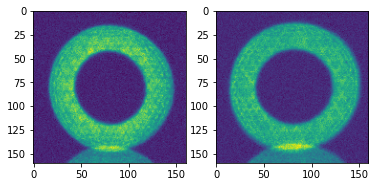

In [8]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(donutStampExtraArray)
fig.add_subplot(1,2,2)
plt.imshow(donutStampIntraArray)

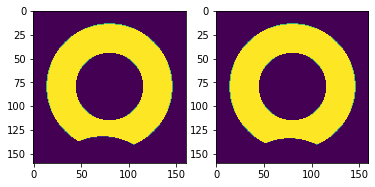

In [9]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(donutStampExtra.stamp_im.getMask().getArray())
fig.add_subplot(1,2,2)
plt.imshow(donutStampIntra.stamp_im.getMask().getArray())

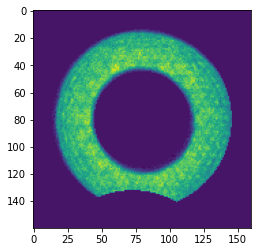

In [10]:
plt.imshow(donutStampExtra.stamp_im.getMask().getArray()*donutStampExtraArray)

In [11]:
camera = butler_orig.get(
    "camera",
    dataId={"instrument": "LSSTComCam"},
    collections="LSSTComCam/calib/unbounded",
)

In [12]:
camera.getName()

'LSSTComCam'

In [13]:
donutCatalogExtra = butler_baseline.get('donutCatalog', dataId=dataIdExtra, collections='ts_phosim_9006001')

In [14]:
donutCatalogIntra = butler_baseline.get('donutCatalog', dataId=dataIdIntra, collections='ts_phosim_9006001')

In [15]:
donutCatalogExtra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,6.279089,-0.004096,2036.840927,2000.876371,3.630781e+06,[2036.8430096447246],[2126.878422663939]


In [16]:
donutCatalogIntra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,6.279089,-0.004096,2036.840927,2000.876371,3.630781e+06,[2036.8430096447246],[2126.878422663939]


In [17]:
x_blend, y_blend = 2036.5, 2054.5
x_blend_2, y_blend_2 = 2036.5, 1945.5

In [18]:
donutCatalogExtra['blend_centroid_x'] = [[x_blend]]
donutCatalogExtra['blend_centroid_y'] = [[y_blend]]

In [19]:
# donutStampsExtra[0].blend_centroid_positions = np.array([[x_blend, y_blend], [x_blend, y_blend_2]])
# donutStampsIntra[0].blend_centroid_positions = np.array([[x_blend, y_blend], [x_blend, y_blend_2]])

In [20]:
zern_est_orig = butler_orig.get('zernikeEstimateRaw', dataId=dataIdExtra, collections='ts_phosim_9006001')

In [21]:
zern_est_blended_baseline = butler_baseline.get('zernikeEstimateRaw', dataId=dataIdExtra, collections='ts_phosim_9006001')

In [22]:
opd_truth = np.genfromtxt('testData/single_blended_original/iter0/img/opd.zer')

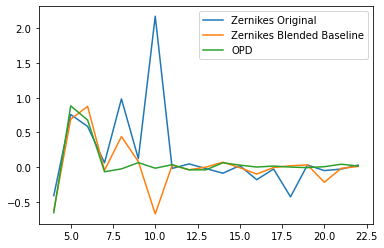

In [23]:
plt.plot(np.arange(4,23), zern_est_orig[0], label='Zernikes Original')
plt.plot(np.arange(4,23), zern_est_blended_baseline[0], label='Zernikes Blended Baseline')
plt.plot(np.arange(4,23), opd_truth[4], label='OPD')
plt.legend()

In [24]:
from lsst.ts.wep.task.CalcZernikesTask import CalcZernikesTask, CalcZernikesTaskConfig

In [25]:
calcZernConfig = CalcZernikesTaskConfig()

In [26]:
calcZernConfig

lsst.ts.wep.task.CalcZernikesTask.CalcZernikesTaskConfig(saveMetadata=True, saveLogOutput=True, combineZernikes={'sigma': 3.0, 'maxZernClip': 3}, connections={'donutStampsExtra': 'donutStampsExtra', 'donutStampsIntra': 'donutStampsIntra', 'outputZernikesRaw': 'zernikeEstimateRaw', 'outputZernikesAvg': 'zernikeEstimateAvg'})

In [27]:
calcZernTask = CalcZernikesTask(config=calcZernConfig)

In [28]:
# donutStampsIntra[0].centroid_position = donutStampsExtra[0].centroid_position

In [29]:
donutStampsExtra[0]

DonutStamp(stamp_im=lsst.afw.image.maskedImage.MaskedImageF=(image=[[ 2.99624939e+01 -2.60750842e+00  1.04204922e+01 ... -1.27359877e+01
   7.18321180e+00  4.33761215e+00]
 [-5.21310854e+00 -3.91030860e+00  2.86596928e+01 ...  1.14516115e+01
  -1.35358787e+00 -4.19918776e+00]
 [-1.30470848e+00  6.51209211e+00  1.56316919e+01 ... -7.04478741e+00
  -1.13131876e+01 -8.46758747e+00]
 ...
 [ 4.07012936e-04 -5.33439255e+00  6.66890669e+00 ...  1.03317490e+01
  -2.71925044e+00  2.50114942e+00]
 [ 2.13396053e+01 -1.33329296e+00  3.46766052e+01 ... -4.02435017e+00
   1.03317490e+01 -1.09050408e-01]
 [-8.00179291e+00 -9.33549213e+00 -1.33329296e+00 ... -1.57702503e+01
  -1.41415036e+00 -1.44651499e+01]],
mask=[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], maskPlaneDict={'BAD': 0, 'BKGRD': 9, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'DONUT': 10, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7}
variance=[[

In [30]:
xShift = donutStampsExtra[0].centroid_position.getX() - donutCatalogExtra['centroid_x']
yShift = donutStampsExtra[0].centroid_position.getY() - donutCatalogExtra['centroid_y']
donutStampsExtra[0].blend_centroid_positions[0] += np.array([xShift.iloc[0], yShift.iloc[0]])

In [31]:
xShift = donutStampsIntra[0].centroid_position.getX() - donutCatalogIntra['centroid_x']
yShift = donutStampsIntra[0].centroid_position.getY() - donutCatalogIntra['centroid_y']
donutStampsIntra[0].blend_centroid_positions[0] += np.array([xShift.iloc[0], yShift.iloc[0]])

In [32]:
zern_est_new = calcZernTask.run(donutStampsExtra, donutStampsIntra)

0
0
0
0
[[-9.26907316e-04  1.26003629e+02]]
8
[[-9.26907316e-04  1.26003629e+02]]
8
[[-9.26907316e-04  1.26003629e+02]]
8
[[-9.26907316e-04  1.26003629e+02]]
8
762.6585745417591
501.7340750385789
415.711108606675
206.5661098966423
785.1353398598294
216.7796851076554
181.3270598042381
116.24469664335744
979.9316173524684
753.8936371368148
619.7948853221784
1122.8273213469433
459.46026819505005
509.62148721686964


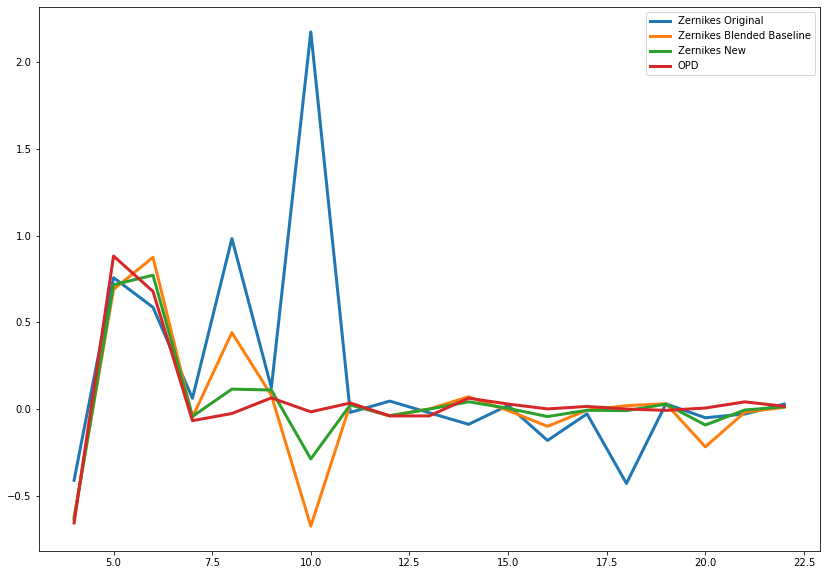

In [103]:
fig = plt.figure(figsize=(14, 10))
plt.plot(np.arange(4,23), zern_est_orig[0], label='Zernikes Original', lw=3)
plt.plot(np.arange(4,23), zern_est_blended_baseline[0], label='Zernikes Blended Baseline', lw=3)
plt.plot(np.arange(4,23), zern_est_new.outputZernikesRaw[0], label='Zernikes New', lw=3)
plt.plot(np.arange(4,23), opd_truth[4], label='OPD', lw=3)
plt.legend()

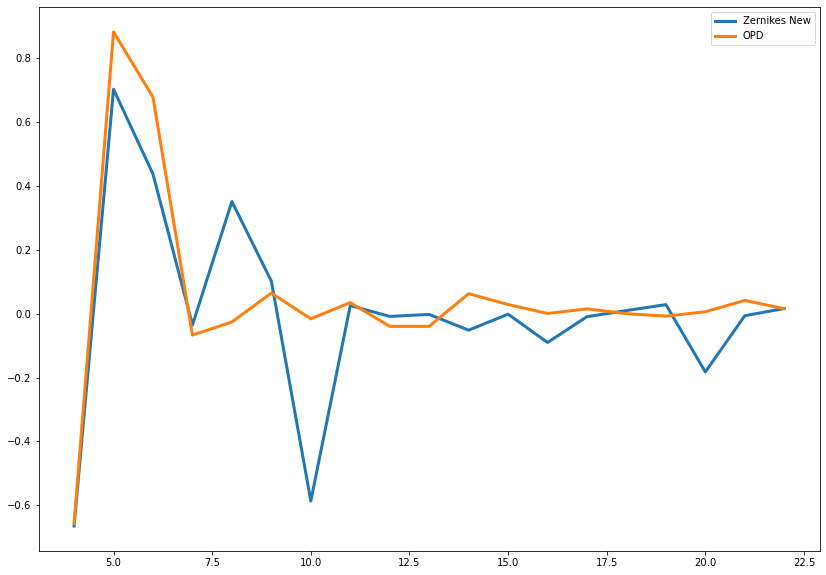

In [33]:
fig = plt.figure(figsize=(14, 10))
#plt.plot(np.arange(4,23), zern_est_orig[0], label='Zernikes Original', lw=3)
#plt.plot(np.arange(4,23), zern_est_blended_baseline[0], label='Zernikes Blended Baseline', lw=3)
plt.plot(np.arange(4,23), zern_est_new.outputZernikesRaw[0], label='Zernikes New', lw=3)
plt.plot(np.arange(4,23), opd_truth[4], label='OPD', lw=3)
plt.legend()
#plt.ylim(-0.7, 0.9)

In [34]:
I1 = np.genfromtxt('I1_00.txt')
I2 = np.genfromtxt('I2_00.txt')
I1_mod = np.genfromtxt('I1_mask_0.txt')
I2_mod = np.genfromtxt('I2_mask_0.txt')

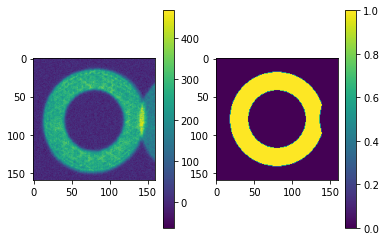

In [35]:
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(I1)
plt.colorbar()
fig.add_subplot(122)
plt.imshow(I1_mod)
plt.colorbar()

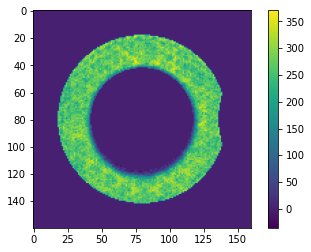

In [36]:
plt.imshow(I1*I1_mod)
plt.colorbar()

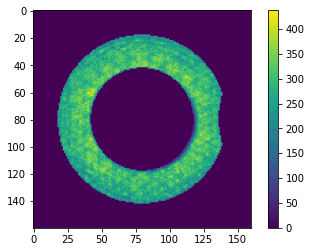

In [37]:
plt.imshow(I2*I2_mod)
plt.colorbar()

In [38]:
I1 = np.genfromtxt('I1_3.txt')
I2 = np.genfromtxt('I2_3.txt')
I1_mod = np.genfromtxt('I1_mask_0.txt')
I2_mod = np.genfromtxt('I2_mask_0.txt')

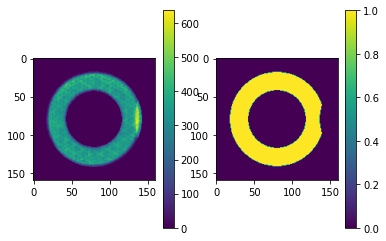

In [39]:
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(I1)
plt.colorbar()
fig.add_subplot(122)
plt.imshow(I1_mod)
plt.colorbar()

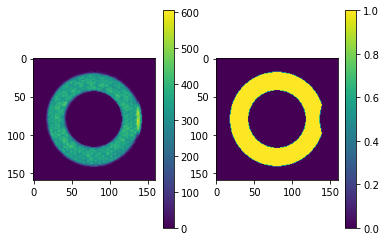

In [40]:
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(I2)
plt.colorbar()
fig.add_subplot(122)
plt.imshow(I2_mod)
plt.colorbar()

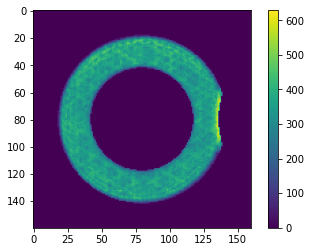

In [41]:
plt.imshow(I1*I1_mod)
plt.colorbar()

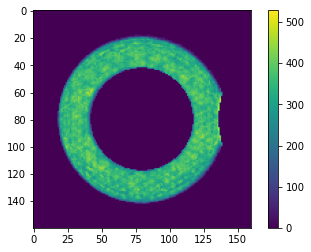

In [42]:
plt.imshow(I2*I2_mod)
plt.colorbar()

In [43]:
i0 = np.genfromtxt('I0_3.txt')
dI = np.genfromtxt('dI_3.txt')

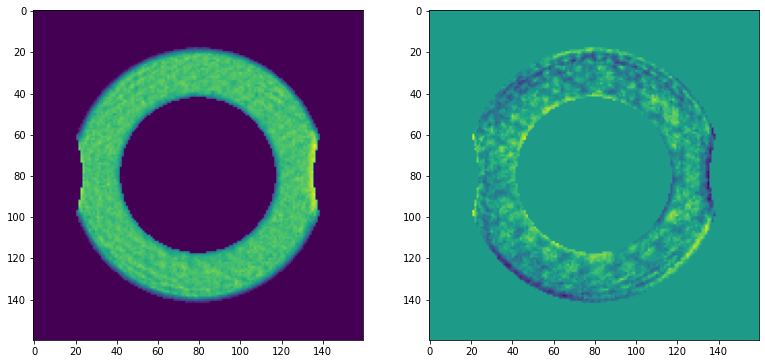

In [44]:
fig = plt.figure(figsize=(13,13))
fig.add_subplot(121)
plt.imshow(i0)
#plt.colorbar()
fig.add_subplot(122)
plt.imshow(dI)
#plt.colorbar()

(array([18219.,   210.,   280.,   397.,  1145.,  3994.,  1164.,    96.,
           61.,    34.]),
 array([  0.        ,  64.1973177 , 128.3946354 , 192.5919531 ,
        256.78927081, 320.98658851, 385.18390621, 449.38122391,
        513.57854161, 577.77585931, 641.97317701]),
 <BarContainer object of 10 artists>)

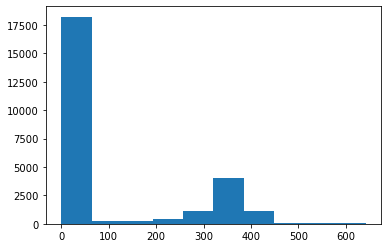

In [205]:
plt.hist((I1*I1_mod).flatten())

In [298]:
from scipy.ndimage import binary_erosion, binary_dilation

In [299]:
np.std(I1*binary_dilation(I1_mod, iterations=6))

160.05769794812744

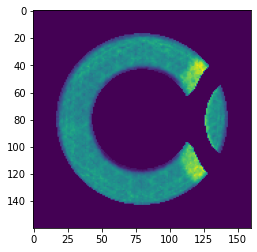

In [301]:
plt.imshow(I1*binary_dilation(I1_mod, iterations=6))

In [314]:
a = np.zeros((11, 11))

In [315]:
a[1,1] = 1
print(a)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [320]:
print(binary_dilation(a, iterations=2)*1.)

[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


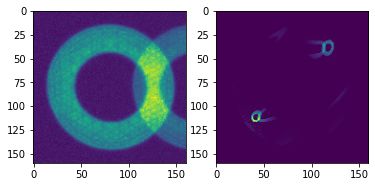

In [249]:
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(I2)
fig.add_subplot(122)
plt.imshow(I2_mod)

In [46]:
I1 = np.genfromtxt('I1.txt')
I2 = np.genfromtxt('I2.txt')
I1_mod = np.genfromtxt('I1_mod.txt')
I2_mod = np.genfromtxt('I2_mod.txt')

[autoreload of lsst.ts.wep.task.CalcZernikesTask failed: Traceback (most recent call last):
  File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.0/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.0/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.0/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.0/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-sci

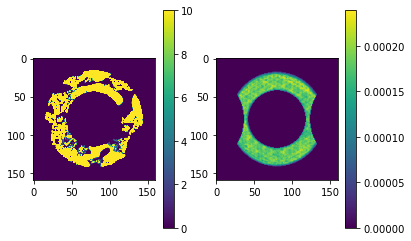

In [47]:
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(I1, vmax=10)
plt.colorbar()
fig.add_subplot(122)
plt.imshow(I1_mod)
plt.colorbar()

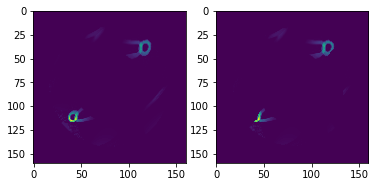

In [192]:
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(I2)
fig.add_subplot(122)
plt.imshow(I2_mod)